# Code Control Flags

In [59]:
collab = False
run_simuls = False
plot_results = False

In [60]:
if collab:
    !pip install scipy
    !pip install matplotlib

# Imports and Settings

In [61]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

In [62]:
HBAR = 1
dpi = 300
plt.style.use('plot_style.txt')
plt.rcParams['figure.constrained_layout.use'] = True
plt.figure(figsize=(14.4, 7.5))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'

<Figure size 1440x750 with 0 Axes>

# Core functions

In [63]:
def Fock_to_Eigen_basis(target, d_matrix):
    '''
        Given a 'target' matrix in the Fock basis and a
        transformation matrix to the Eigen basis, returns
        the similarity transformation of the target as follows:

        $D^{*}AD$

        Arguments:
            target (numpy array, N-by-N): target matrix in the Fock
                                          basis to be transformed
            d_matrix (numpy array, N-by-M): Fock-to-Eigen
                                            transformation matrix
        Returns:
            transformed_matrix (numpy array, M-by-M): matrix in
                                                      Eigen basis
    '''
    d_matrix_t = np.transpose(d_matrix)
    transformed_matrix = d_matrix_t @ target @ d_matrix
    return transformed_matrix


def make_Eigen_real(vecs):
    '''
        Transformed Eigenvectors from complex to real (BRUTE FORCE)

        Arguments:
        vecs (numpy.ndarray): The matrix of eigenvectors.

        Returns:
        numpy.ndarray: The matrix of real eigenvectors.

    '''
    ndim1, ndim2 = vecs.shape
    for i in range(ndim2):
        temp = vecs[:, i].imag
        if(temp.any() != 0):
            raise ValueError(f'[make_Eigen_real] Error. > {temp}'
                             'Imaginary part of Eigenvector not zero')
    return np.real(vecs)


def destroy_q(N, offset=0):
    '''
        Generates the annihilation (lowering) operator for a quantum system.

        Arguments:
        N (int): The dimension of the Hilbert space.
        offset (int, optional): The offset for subdiagonal location. Defaults to 0.

        Returns:
        numpy.ndarray: The annihilation operator off-diagonal matrix.
    '''
    if not isinstance(N, (int, np.integer)):  # raise error if N not integer
        raise ValueError("Hilbert space dimension must be integer value")
    data = np.sqrt(np.arange(offset + 1, N + offset, dtype=complex))
    return np.diag(data[:], 1)


def create_q(N, offset=0):
    '''
        Generates the creation (raising) operator for a quantum system. 
        (adjoint of destruction operator)

        Arguments:
        N (int): The dimension of the Hilbert space.
        offset (int, optional): The offset for subdiagonal location. Defaults to 0.

        Returns:
        numpy.ndarray: The creation operator matrix.
    '''
    if not isinstance(N, (int, np.integer)):  # raise error if N not integer
        raise ValueError("Hilbert space dimension must be integer value")
    q0 = destroy_q(N, offset=offset)
    return np.conjugate(q0.T)


def x_op(N, c=1):
    '''
        Generates the position operator for a quantum system.

        Arguments:
        N (int): The dimension of the Hilbert space.
        c (float, optional): Scaling constant for the position operator.
                             Defaults to 1.

        Returns:
        numpy.ndarray: The position operator matrix.
    '''
    return c * (destroy_q(N) + create_q(N)) / np.sqrt(2)


def p_op(N, c=1, hbar=HBAR):
    '''
        Generates the momentum operator for a quantum system.

        Arguments:
        N (int): The dimension of the Hilbert space.
        c (float, optional): Scaling constant for the momentum operator.
                             Defaults to 1.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        numpy.ndarray: The momentum operator matrix.
    '''
    return 1j * hbar * (create_q(N) - destroy_q(N)) / np.sqrt(2) / c


def ladder_op(N, c=1, hbar=HBAR, dagger=False):
    '''
        Generates the ladder (creation or annihilation) operator for a
        quantum system based upon the position and momentum operator
        representations.

        Arguments:
        N (int): The dimension of the Hilbert space.
        c (float, optional): Scaling constant for the ladder operator.
                             Defaults to 1.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR=1.
        dagger (bool, optional): If True, returns the creation operator;
                                 otherwise, returns the annihilation operator.
                                 Defaults to False.

        Returns:
        numpy.ndarray: The ladder operator matrix.
    '''

    x_comp = x_op(N, 1) / c
    p_comp = 1j * c * p_op(N, 1) / hbar
    if dagger:
        p_comp *= -1
    return (x_comp + p_comp) / np.sqrt(2)


def kerr_cat_hamiltonian(N, K, epsilon_2, delta, epsilon_1, hbar=HBAR):
    '''
        Implements the asymmetric Kerr-Cat Hamiltonian based on the following
        expression:

        $$
        H = delta * (a_dag * a)
            - K * (a_dag)^2a^2
            + epsilon_2 ((a_dag)^2 + a^2)
            + epsilon (a_dag + a)
        $$
        Arguments:
        N (int): The dimension of the Hilbert space.
        K (float): Kerr nonlinearity constant.
        epsilon_2 (float): Squeezing drive amplitude.
        delta (float): Detuning parameter.
        epsilon_1 (float): Asymmetry parameter.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        numpy.ndarray: The Kerr-cat Hamiltonian matrix.


    '''
    # Hamiltonian basis operators
    ac = destroy_q(N)
    ac_dag = create_q(N)
    # Term-by-term construction
    ac_sq = ac @ ac  # a^2
    ac_dag_sq = ac_dag @ ac_dag  # (a^+) ^2
    nc = ac_dag @ ac  # a a^+
    kc_sq = ac_dag_sq @ ac_sq  # (a^+)^2 a^2
    xc = ac_dag + ac  # (a^+ + a)
    xc_sq = ac_dag_sq + ac_sq  # (a^+)^2 + a^2

    # hamiltonian
    H = (delta * nc - K * kc_sq + epsilon_2 * xc_sq + epsilon_1 * xc)
    return -1 * H / hbar


def get_V_dw(x, k4, k2, k1, grid=False):
    '''
        Generates the chemical potential V(x) defined with prefactors
        k4, k2, k1 determining the potential shape.

        $$ V(x) = k_{4} x^{4} - k_{2} x^{2} + k_{1} x $$

        Arguments:
        x (numpy.ndarray): Position operator (or grid) at which to evaluate the
                           potential.
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        k1 (float): Coefficient for the linear term.
        grid (bool, optional): If True, returns the potential on a grid.
                               Defaults to False.

        Returns:
        numpy.ndarray: The value(s) of the double-well potential.
    '''
    if not grid:
        x_sq = np.matmul(x, x)
        x_qt = np.matmul(x_sq, x_sq)
    else:
        x_sq = x**2
        x_qt = x_sq**2
    return k4*x_qt - k2*x_sq + k1*x


def get_H_dw(x, p, m, k4, k2, k1):
    '''
        Constructs the Hamiltonian for the chemical double-well potential
        system.

        $$ H = \frac{p^{2}}{2m} + V(x) $$

        Arguments:
        x (numpy.ndarray): Position operator.
        p (numpy.ndarray): Momentum operator.
        m (float): Mass of the particle.
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        k1 (float): Coefficient for the linear term.

        Returns:
        numpy.ndarray: The Hamiltonian matrix for the double-well system.
    '''
    p_sq = np.matmul(p, p)
    return p_sq/(2*m) + get_V_dw(x, k4, k2, k1)


def get_H_dw_fock(create_q, destroy_q, m, k4, k2, k1, c=1.0, hbar=HBAR):
    '''
        Constructs the Hamiltonian for the chemical double-well potential
        system in the Fock basis representation.

        $$ H = \frac{p^{2}}{2m} + V(x) $$

        Arguments:
        create_q (numpy.ndarray): Creation operator.
        destroy_q (numpy.ndarray): Annihilation operator.
        m (float): Mass of the particle.
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        k1 (float): Coefficient for the linear term.
        c (float, optional): Lengthscale scaling constant. Defaults to 1.0.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        numpy.ndarray: The Hamiltonian matrix in the Fock basis.
    '''
    p = (destroy_q - create_q) / c / np.sqrt(2)
    x = (destroy_q + create_q) * c / np.sqrt(2)
    p_sq = np.matmul(p, p)
    return - hbar**2 * p_sq/(2*m) + get_V_dw(x, k4, k2, k1)


def get_H_kc(x, p, m, k4, k2, k1, c=1.0, hbar=HBAR):
    '''
        Generates the Kerr-Cat Hamiltonian in phase space representation, by
        adding the 4th order momentum and mixed momentum/position operators
        to the chemical double-well potential.

        Arguments:
        x (numpy.ndarray): Position operator.
        p (numpy.ndarray): Momentum operator.
        m (float): Mass of the particle.
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        k1 (float): Coefficient for the linear term.
        c (float, optional): Lengthscale scaling constant. Defaults to 1.0.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        numpy.ndarray: The Hamiltonian matrix for the Kerr-Cat model in phase
                       space representation.
    '''
    dw_segment = get_H_dw(x, p, m, k4, k2, k1)
    K = get_K(k4, c)
    x_sq = np.matmul(x, x)
    p_sq = np.matmul(p, p)
    p_qt = np.matmul(p_sq, p_sq)
    kc_segment = 0.25/hbar**4 * K * (c**4*p_qt
                                     + np.matmul(x_sq, p_sq)
                                     + np.matmul(p_sq, x_sq))
    return dw_segment + kc_segment


def get_K(k4, c):
    '''
        Computes the Kerr nonlinearity constant, K, in terms of chemical
        variables and lengthscale correspondence 'c' constant.

        Arguments:
        k4 (float): Coefficient for the quartic term.
        c (float): Lengthscale scaling constant.

        Returns:
        float: The Kerr nonlinearity constant.
    '''
    return 4 * c**4 * k4


def get_Delta(k4, k2, m, c, hbar=HBAR):
    '''
        Computes the detuning parameter, Delta, in terms of chemical
        variables and lengthscale correspondence 'c' constant.

        Arguments:
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        m (float): Mass of the particle.
        c (float): Lengthscale scaling constant.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        float: The detuning parameter.
    '''
    return c**2 * k2 - hbar**2 / (2 * m * c**2) - 2 * get_K(k4, c)


def get_epsilon2(k2, m, c, hbar=HBAR):
    '''
        Expression for driving amplitude, epsilon2, in terms of chemical
        variables and lengthscale correspondence 'c' constant.

        Arguments:
        k2 (float): Coefficient for the quadratic term.
        m (float): Mass of the particle.
        c (float): Lengthscale scaling constant.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        float: The driving amplitude.
    '''
    return c**2 * k2 / 2 + hbar**2 / (4 * m * c**2)


def get_epsilon1(k1, c):
    '''
        Computes the asymmetry parameter epsilon1 in terms of chemical
        variables and lengthscale correspondence 'c' constant.

        Arguments:
        k1 (float): Coefficient for the linear term.
        c (float): Lengthscale scaling constant.

        Returns:
        float: The asymmetry parameter.
    '''
    return - k1 * c / np.sqrt(2)


def gen_KC_params_from_DW(m, k4, k2, k1, c=1.0):
    '''
        Generates the Kerr-cat parameters from double-well parameters.

        Arguments:
        m (float): Mass of the particle.
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        k1 (float): Coefficient for the linear term.
        c (float, optional): Lengthscale scaling constant. Defaults to 1.0.

        Returns:
        dict: A dictionary containing the Kerr-cat parameters.
    '''
    K = get_K(k4, c)
    Delta = get_Delta(k4, k2, m, c)
    e2 = get_epsilon2(k2, m, c)
    e1 = get_epsilon1(k1, c)
    return (K, Delta, e2, e1)


def len_white_space(lwspace, lstr):
    ''' 
        Calculates the length of leading white space to pad a string.

        Arguments:
        lwspace (str): The length of the desired white space.
        lstr (str): The target string.

        Returns:
        int: The length of the leading white space.
    '''
    lws = (lwspace - len(lstr)) / 2
    return (int(np.ceil(lws)), int(np.floor(lws)))


def pretty_print(m, k4, k2, k1, c, print_header=False, K_units=True):
    '''
        Pretty-prints the parameters of a double-well mapped onto the
        Kerr-Car formalism.

        Arguments:
        m (float): Mass of the particle.
        k4 (float): Coefficient for the quartic term.
        k2 (float): Coefficient for the quadratic term.
        k1 (float): Coefficient for the linear term.
        c (float): Lengthscale scaling constant.
        print_header (bool, optional): If True, prints a header.
                                       Defaults to False.
        K_units (bool, optional): If True, prints Kerr-cat parameters in
                                  Kerr units. Defaults to True.

        Returns:
        None
    '''

    K, Delta, e2, e1 = gen_KC_params_from_DW(m, k4, k2, k1, c)

    str_Delta = 'D'
    str_e2 = 'e2'
    str_e1 = 'e1'

    if K_units:
        Delta /= K
        e2 /= K
        e1 /= K
        str_Delta = str_Delta + '/K'
        str_e2 = str_e2 + '/K'
        str_e1 = str_e1 + '/K'

    if print_header:
        plwD, slwD = len_white_space(13, str_Delta)
        plwe2, slwe2 = len_white_space(13, str_e2)
        plwe1, slwe1 = len_white_space(13, str_e1)

        print('   c   |',
              ' '*6, 'K', ' '*6, '|',
              ' '*plwD, str_Delta, ' '*slwD, '|',
              ' '*plwe2, str_e2, ' '*slwe2, '|',
              ' '*plwe1, str_e1, ' '*slwe1, '|', sep='')
        print('-'*65)

    if K_units:
        print(f' {c:1.3f} | {K:+1.8f} | {Delta:+1.4E} |'
              f' {e2:+1.4E} | {e1:+1.4E} |', sep='')
    else:
        print(f' {c:1.3f} | {K:+1.8f} | {Delta:+1.8f} |'
              f' {e2:+1.8f} | {e1:+1.8f} |', sep='')


def get_dissipator_xp(N, kappa, nth, c=1, basis_change_matrix=None,
                      hbar=HBAR):
    '''
        Constructs the dissipator for the quantum system using a position
        and momentum operator basis.

        Arguments:
        N (int): The dimension of the Hilbert space.
        kappa (float): Bath coupling damping coefficient.
        nth (float): Bath thermal parameter.
        c (float, optional): Lengthscale scaling constant. Defaults to 1.0.
        basis_change_matrix (numpy.ndarray, optional): Basis change matrix for
                                                       operator transformation.
                                                       Defaults to None.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        numpy.ndarray: The dissipator matrix.
    '''
    # operator definitions
    ac = ladder_op(N, c, hbar)
    ac_dag = ladder_op(N, c, hbar, dagger=True)
    if basis_change_matrix is not None:
        assert N == basis_change_matrix.shape[0]
        ac = Fock_to_Eigen_basis(ac, basis_change_matrix)
        ac_dag = Fock_to_Eigen_basis(ac_dag, basis_change_matrix)
    d_op = len(ac)

    aa_dag = ac @ ac_dag
    a_daga = ac_dag @ ac
    eye = np.eye(d_op)

    # dissipator definitions
    Da = (np.kron(ac_dag, ac_dag)
          - 0.5 * (np.kron(eye, aa_dag) + np.kron(aa_dag, eye)))
    Dadag = (np.kron(ac, ac)
             - 0.5 * (np.kron(eye, a_daga) + np.kron(a_daga, eye)))

    return kappa * ((1 + nth) * Dadag + nth * Da)


def get_lindbladian_xp(H, kappa, nth, c=1.0, basis_change_matrix=None,
                       hbar=HBAR):
    '''
        Constructs the Lindbladian superoperator for a quantum system
        using a position and momentum operator basis.


        Arguments:
        H (numpy.ndarray): The system Hamiltonian.
        kappa (float): Bath coupling damping coefficient.
        nth (float): Bath thermal parameter.
        c (float, optional): Lengthscale scaling constant. Defaults to 1.0.
        basis_change_matrix (numpy.ndarray, optional): Basis change matrix for
                                                       operator transformation.
                                                       Defaults to None.
        hbar (float, optional): Reduced Planck's constant. Defaults to HBAR.

        Returns:
        numpy.ndarray: The Lindbladian superoperator.
    '''
    d = len(H)  # dimension of the system

    if basis_change_matrix is not None:
        assert d == basis_change_matrix.shape[0]
        H = Fock_to_Eigen_basis(H, basis_change_matrix)

    dH = len(H)

    # Hamiltonian part
    superH = -1j / hbar * (np.kron(np.eye(dH), H)
                           - np.kron(H.T, np.eye(dH)))
    superL = get_dissipator_xp(d, kappa, nth, c, basis_change_matrix,
                               hbar)
    return superH + superL


def Liouvillian(H, Ls, hbar=1):
    '''
        Constructs the Liouvillian superoperator for a quantum system.

        Arguments:
        H (numpy.ndarray): The system Hamiltonian.
        Ls (list): List of Lindblad operators.
        hbar (float, optional): Reduced Planck's constant. Defaults to 1.

        Returns:
        numpy.ndarray: The Liouvillian superoperator.
    '''

    d = len(H)  # dimension of the system
    # Hamiltonian part
    superH = -1j / hbar * (np.kron(np.eye(d), H) - np.kron(H.T, np.eye(d)))
    # L* \otimes L - 1/2 (1 \otimes L^{dag} @ L + L^T @ L^* \otimes 1)
    superL = sum([np.kron(L.conjugate(), L)
                  - 1 / 2 * (np.kron(np.eye(d), L.conjugate().T.dot(L)) +
                             np.kron(L.T.dot(L.conjugate()), np.eye(d))
                             ) for L in Ls])
    return superH + superL


def propagation_by_semigroup(rho0, superop, dt=0.5, m=20):
    '''
        Propagates for a density matrix rho0 with a superoperator for
        m timesteps in increments of dt (superoperator propagates for only
        a single step)

        Arguments:
        rho0 (numpy.ndarray): The initial density matrix.
        superop (numpy.ndarray): The semigroup superoperator.
        dt (float, optional): Time step for propagation. Defaults to 0.5.
        m (int, optional): Number of time steps. Defaults to 20.

        Returns:
        numpy.ndarray: The propagated density matrix after m time steps.
    '''
    d = len(rho0)  # dimension or the state
    P = scipy.linalg.expm(superop * dt)  # propagator
    times, rhos = [], []  # allocate lists
    # times, pops = [], []  # allocate lists
    t, rho = 0.0, rho0  # initialise
    # propagate
    # for k in range(m):
    k = 0
    while k < m:
        rhos.append(rho)
        times.append(t)  # append current time
        # propagate time and state
        t, rho = t + dt, np.reshape(P.dot(np.reshape(rho, (d**2, 1))), (d, d))
        k += 1
    return (np.array(times), np.array(rhos))


def get_obs_traces(rhots, obs):
    r'''
        Computes the partial trace of the observable over a series of density
        matrices.

        $\text{Tr}\\{ \rho _t \rho _{\text{obs}}\\}$

        Arguments:
        rhots (list of numpy.ndarray): List of density matrices or a 3D array
                                       with the time evolution of the density
                                       matrix.
        obs (numpy.ndarray): The observable to trace.

        Returns:
        numpy.ndarray: The trace of the observable at each time step.
    '''
    obs_t = []
    for rhot in rhots:
        obs_t.append(np.real(np.trace(rhot @ obs)))
    return np.array(obs_t)


def get_QHO_basis(q, level, max_level=250):
    '''
        Generates the basis states of a quantum harmonic oscillator.

        Arguments:
        q (numpy.ndarray): Position grid points.
        level (int): The level of the quantum harmonic oscillator.
        max_level (int, optional): Maximum level of the basis states.
                                   Defaults to 250.

        Returns:
        numpy.ndarray: The basis states of the quantum harmonic oscillator.
    '''
    # harmonic oscillator eigenfunctions in position representation
    if level > max_level:
        print(f"ERROR WARNING: REPRESENTATION FAILS BECAUSE {level}! is large"
              f"Setting level={level} to level=MAX_LEVEL={max_level}")
        level = max_level
    norm = (1. / np.pi)**.25 / np.sqrt(2.**level * special.factorial(level))
    hermite_polynomial = special.hermite(level)(q)
    gaussian_factor = np.exp(-q**2 / 2.)
    return norm * hermite_polynomial * gaussian_factor


def get_grid_init_state_in_fock(levels, grid_state,
                                n_grid_pts=None, grid_bound=None):
    '''
        Given a number of QHO levels and a grid-based initial state,
        generates the initial state representation in terms of fock
        states.

        Adapted from code sample by Pouya Khazaei

        Arguments:
        levels (int): Number of levels in the Fock basis.
        grid_state (numpy.ndarray): The initial state in grid representation.
        n_grid_pts (int, optional): Number of grid points. Defaults to None.
        grid_bound (float, optional): The boundary of the grid.
                                      Defaults to None.

        Returns:
        numpy.ndarray: The initial state in the Fock basis.
    '''
    if n_grid_pts is None or grid_bound is None:
        n_grid_pts = grid_state.size
        grid_bound = (max(grid_state) - min(grid_state)) / 2
    # grid
    x = np.linspace(-grid_bound, grid_bound, n_grid_pts)
    # array for fock state coefficient
    wav = np.zeros(levels)
    # make initial gaussian wavepacket
    for i in range(levels):
        qho_basis = get_QHO_basis(x, i)
        # get expansion coeffs by projecting eigenfxns on gaussian init state
        wav[i] = simpson(np.conj(qho_basis) * grid_state, x)
    return wav / np.linalg.norm(wav)


def get_fock_init_state_in_gaussian_grid(fock_state, n_grid_pts, grid_bound,
                                         levels=None):
    '''
        Given a particular fock state returns its grid based representation
        for a given number of grid points and grid boundary.

        Adapted from code sample by Pouya Khazaei

        Arguments:
        fock_state (numpy.ndarray): The initial state in the Fock basis.
        n_grid_pts (int): Number of grid points.
        grid_bound (float): The boundary of the grid.
        levels (int, optional): Number of levels in the Fock basis.
                                Defaults to None.

        Returns:
        numpy.ndarray: The initial state in the Gaussian grid representation.

        Test:
        ng = 5000 # size of grid
        l = 10 # grid goes between -l and l

        fock_state = np.array([0, 1, 0], dtype=float)
        fock_state /= np.linalg.norm(fock_state)
        x_fock, gaussianfock = get_fock_init_state_in_gaussian_grid(
                                                        fock_state, ng, l)
        plt.plot(x_fock, gaussianfock)
        plt.show()
    '''
    fock_state = np.array(fock_state)
    fock_state = fock_state / np.linalg.norm(fock_state)
    if levels is None:
        levels = fock_state.size
    # grid
    x = np.linspace(-grid_bound, grid_bound, n_grid_pts)
    # use coeffs to get position wavefxn with QHO wavefunctions
    wav_pos = np.zeros(n_grid_pts)
    for i in range(levels):
        qho_basis = get_QHO_basis(x, i)
        # use coeffs to make the initial state with the HO wavefunctions
        wav_pos += fock_state[i] * qho_basis
    return x, wav_pos


def get_sigmoidal(x, x0=0.0, tail=1.0):
    '''
        Computes the sigmoidal function for a given input.

        Note: sigmoidal function should have negative exponent;
        ie 1/ (1+e^(-(x-x0)/tail)) according to the definition

        Arguments:
        x (numpy.ndarray): Input values.
        x0 (float, optional): The inflection point of the sigmoidal function.
                              Defaults to 0.0.
        tail (float, optional): The tail of the sigmoidal function.
                                Defaults to 1.0.

        Returns:
        numpy.ndarray: The output of the sigmoidal function.
    '''
    sigmoidal = []
    for y in x:
        sigmoidal.append(1 / (1 + np.exp((y - x0) / tail)))
    return np.array(sigmoidal)


def get_heaviside(x, x0=0.0):
    '''
        Computes the Heaviside step function for a given input.

        Arguments:
        x (numpy.ndarray): Input values.
        x0 (float, optional): The step location of the Heaviside function.
                              Defaults to 0.0.

        Returns:
        numpy.ndarray: The output of the Heaviside step function.
    '''
    heaviside = np.array([1 if y > x0 else 0 for y in x])
    return heaviside


def filter_state_by_xvalues(all_states, n_grid_pts, grid_bound, x_split=0.,
                            cutoff=0.5, left=True, filter_type=None,
                            sigmoidal_tail=1.0, return_state=False):
    '''
        Find the first state in the Fock basis representation satisfying 
        a LHS/RHS criteria, convert the selected state to the grid
        representation and apply a filtering function (if optioned), and
        return the filtered state in the Fock basis representation.

        The LHS criteria is defined as:
                |psi(x<x_split)|^2 > cutoff
        whereas the RHS criteria is defined as:
                |psi(x>x_split)|^2 > cutoff

        Inputs:
            - all_states: (list or np.array)
                    List or array of eigenstates defined in Fock Basis
            - n_grid_pts: (int)
                    Specifies number of points to use in grid construction
            - grid_bound: (float)
                    Specifies the outer limits of the position grid.
            - x_split: (float)
                    The central value used to divide xgrid into LHS/RHS.
            - cutoff: (float)
                    The probability cutoff to use.
            - left: (bool)
                    Specifies whether to filter based on the LHS or RHS.
            - filter_type: ('H' or 'S')
                    String specifying how to filter things; currently not used
            - sigmoidal_tail (float)
                    Determines the decay rate of the sigmoidal tail
                    (only used if filter_type='S')
                    (default=1.0)
            - return_state (bool)
                    Determines whether to return the final state and index
                    (default=False)

        Returns:
            First state matching filter criteria in the Fock basis
            representation.

    '''
    # Define position grid:
    xgrid = np.linspace(-grid_bound, grid_bound, n_grid_pts)
    # Grab indices of the x-grid for the left/right
    if left:
        x_indices = np.argwhere(xgrid < x_split)
    else:
        x_indices = np.argwhere(xgrid > x_split)

    # Loop over eigenstates, checking each for criteria
    n_eigenstates = len(all_states)

    for ii in range(n_eigenstates):
        tmp_state = all_states[:, ii]

        # Convert from Fock to Coordinate Space
        xs, input_state = get_fock_init_state_in_gaussian_grid(tmp_state,
                                                               n_grid_pts,
                                                               grid_bound)

        # Compute the probability density
        prob_density = input_state**2

        # Get probability in region of interest
        prob_reduced = prob_density[x_indices].sum()
        prob_reduced = prob_reduced / prob_density.sum()

        # Check if probability in region of interest is above cutoff and apply
        # filter.
        if prob_reduced >= cutoff:

            if filter_type is None:
                filtered_state = input_state

            elif filter_type == 'H':
                # TODO make product of two vectors to support other filters``
                # Eliminate other values based on Heaviside
                filtered_state = np.zeros_like(input_state)
                filtered_state[x_indices] = input_state[x_indices]
                # filter_vector = get_heaviside(xgrid, x_split)
                # filtered_state = np.multiply(filter_vector, input_state)

            elif filter_type == 'S':
                filter_vector = get_sigmoidal(xgrid, x_split, sigmoidal_tail)
                if left:
                    filtered_state = np.multiply(filter_vector, input_state)
                else:
                    filtered_state = np.multiply(
                        np.flip(filter_vector), input_state)

            else:
                raise ValueError('[filter_state_by_xvalues]. Error. '
                                 f'filter_type={filter_type} not implemented.'
                                 'Use one of [None, "H", "S"]')

            # Convert to Fock space
            output_fock = get_grid_init_state_in_fock(n_eigenstates,
                                                      filtered_state,
                                                      n_grid_pts, grid_bound)
            output_fock = output_fock / np.linalg.norm(output_fock)
            side = ''
            if left:
                side = 'left'
            else:
                side = 'right'
            print(f'found state {ii} matching {cutoff*100}% '
                  f'density on the {side}')
            if return_state:
                return (output_fock, ii)
            else:
                return output_fock
        else:
            pass
    raise ValueError('[filter_state_by_xvalues]. Error. '
                     'Could not find state satisfying criteria')


def get_heaviside_observable(levels, n_grid_pts, grid_bound, x0=0.0):
    '''
        Generates the Heaviside observable for a quantum system based on
        x-values.

        Arguments:
        levels (int): Number of levels in the quantum system.
        n_grid_pts (int): Number of grid points.
        grid_bound (float): The boundary of the grid.
        x0 (float, optional): The step location of the Heaviside function.
                              Defaults to 0.0.

        Returns:
        numpy.ndarray: The Heaviside observable matrix.
    '''
    # define grid
    x = np.linspace(-grid_bound, grid_bound, n_grid_pts)

    # define grid
    heav = get_heaviside(x, x0)

    # construct Heaviside observable
    obs = np.zeros([levels, levels])
    for i in range(levels):
        psi_i = get_QHO_basis(x, i).conj()
        for j in range(levels):
            psi_j = get_QHO_basis(x, j)
            integrand = psi_i * psi_j * heav
            obs[i, j] = simpson(integrand, x)

    return obs

# Replacement Class for Argparse

In [64]:
class SimArguments:
    def __init__(self, basis_type='E', nbasis_fock=100, nbasis_eigen=20, mass=1836.0,
                 k4=1.0, k2=1.0, k1=1.0, c_min=0.01, c_max=1.0, c_inc=0.1,
                 gamma=0.1, nbar=0.5, t_min=0.0, t_max=10000., t_num=1000, grid_pts=5000,
                 grid_lims=10, x_cutoff=0., cutoff_value=0.5, sigmoidal_tail=0.5,
                 filter_type=None, hamiltonian='KC', system_name='sysname',
                 LDWcvar=False, gammaK=False, time_ratio_gn=True):
        '''
        basis_type (str): Type of basis (Fock or Eigen) to use(default: E)
        nbasis_fock (int): Number of Fock basis (default: 100)
        nbasis_eigen (int): Number of Eigen basis (default: 20)
        mass (float): Mass for kinetics problem(default: 1836. amu for proton)
        k4 (float): Quartic position coefficient for chemical double well;
                    Controls potential walls (default: 1.)
        k2 (float): Quadratic position coefficient for chemical double well;
                    Controls barrier walls (default: 1.)
        k1 (float): Linear position coefficient for chemical double well;
                    Controls floater-well asymmetry (default: 1.)
        c_min (float): Minimun C mapping parameter (default: 0.4)
        c_max (float): Maximun C mapping parameter (default: 0.31); upperbound is
                       included, (ie c_max = c_max + c_step)
        c_inc (float): Step C mapping parameter (default: 0.1)
        gamma (float): Dissipation gamma parameter (default: 0.1)
        nbar (float): Dissipation nbar parameter (default: 0.5)
        t_min (float): Minimun propagation time (default: 0.)
        t_max (float): Maximun propagation time (default: 100.)
        t_num (float): Number of propagation steps (default: 1000)
        grid_pts (int): Number of points for grid representation (default: 5000)
        grid_lims (float): Maximum grid limit (default: 10)
        x_cutoff (float): Cutoff x0 for LHS/RHS initial condition selection
                          (default: 0.)
        cutoff_value (float): Cutoff probability for LHS/RHS init condition
                              selection (default: 0.5)
        sigmoidal_tail (float): Decay of sigmoidal filter (default: 0.5)
        filter_type (str): Filter type for initial condition(default: None)
        hamiltonian (str): Hamiltonian type for dynamics(default: KC)
        system_name (str): Name of the system being studied
        LDWcvar (bool): Whether to enable variable c for DW
        gammaK (bool): Whether to enable gamma dependence on K
        time_ratio_gn (bool): Whether to enable time array dependence on gamma and
                              nth dissipation parameters (ie smaller dissipation
                              params require longer time for decay to be observed)
        '''
        self.basis_type = basis_type
        self.nbasis_fock = nbasis_fock
        self.nbasis_eigen = nbasis_eigen
        #  potential parameters
        self.mass = mass
        self.k4 = k4
        self.k2 = k2
        self.k1 = k1
        #  mapping parameters
        self.c_min = c_min
        self.c_max = c_max
        self.c_inc = c_inc
        #  dissipation parameters
        self.gamma = gamma
        self.nbar = nbar
        #  propagation timerange
        self.t_min = t_min
        self.t_max = t_max
        self.t_num = t_num
        #  initial state parameters
        self.grid_pts = grid_pts
        self.grid_lims = grid_lims
        self.x_cutoff = x_cutoff
        self.cutoff_value = cutoff_value
        self.sigmoidal_tail = sigmoidal_tail
        self.filter_type = filter_type
        #  hamiltonian model
        self.hamiltonian = hamiltonian
        self.system_name = system_name
        self.LDWcvar = LDWcvar
        self.gammaK = gammaK
        self.time_ratio_gn = time_ratio_gn

    
    def print_oqd_params(self):
        #  print to screen
        print('Simulation parameters')
        print('System = ', self.system_name)
        print('basis_type = ', self.basis_type)
        print('nbasis Fock = ', self.nbasis_fock)
        print('nbasis Eigen = ', self.nbasis_eigen)
        print(f'Potential parameters - mass = {self.mass}')
        print(f'Potential parameters - k4 = {self.k4}')
        print(f'Potential parameters - k2 = {self.k2}')
        print(f'Potential parameters - k1 = {self.k1}')
        print(f'C-values range = ({self.c_min},  {self.c_max},  {self.c_inc})')
        print(f'Dissipator parameters - gamma = {self.gamma:1.4e}')
        print(f'Dissipator parameters - nbar = {self.nbar:1.4e}')
        # print(f'Timestep parameters - dt = {self.dt:1.4f}')
        # print(f'Timestep parameters - total T = {self.T:.2f}')
        print('Initial state parameters - filter_type = ', self.filter_type)
        print('Hamiltonian - ham_type = ', self.hamiltonian)

In [65]:
def print_oqd_params(system, basis_type, nbasis_fock, nbasis_eigen,
                     mass, k4, k2, k1, cmin, cmax, cinc,
                     gamma, nbar,
                     dt, T, filter_type, ham_type):
    #  print to screen
    print('Simulation parameters')
    print('System = ', system)
    print('basis_type = ', basis_type)
    print('nbasis Fock = ', nbasis_fock)
    print('nbasis Eigen = ', nbasis_eigen)
    print(f'Potential parameters - mass = {mass}')
    print(f'Potential parameters - k4 = {k4}')
    print(f'Potential parameters - k2 = {k2}')
    print(f'Potential parameters - k1 = {k1}')
    print(f'C-values range = ({cmin},  {cmax},  {cinc})')
    print(f'Dissipator parameters - gamma = {gamma:1.4e}')
    print(f'Dissipator parameters - nbar = {nbar:1.4e}')
    print(f'Timestep parameters - dt = {dt:1.4f}')
    print(f'Timestep parameters - total T = {T:.2f}')
    print('Initial state parameters - filter_type = ', filter_type)
    print('Hamiltonian - ham_type = ', ham_type)

# Main Dynamics Function

In [66]:
def get_op_prep(x, p, mass, k4, k2, k1, cval,
                gamma, nbar, grid_pts, grid_lims,
                x_cutoff, cutoff_value, filter_type,
                sigmoidal_tail,
                nbasis_eigen=1, basis_type='E', H_type='KC',
                obs_heaviside=None, LDWcvar=False):
    """
    Prepares the operators for the quantum evolution and observable evaluation
    of double-well like Hamiltonians based upon physical parameters.

    Parameters:
    x (array-like): The position operator matrix for the system.
    p (array-like): The momentum operator matrix for the system.
    mass (float): The mass of the particle or system coordinate under 
                  consideration.
    k4 (float): The coefficient for the quartic term in the potential.
    k2 (float): The coefficient for the quadratic term in the potential.
    k1 (float): The coefficient for the linear term in the potential.
    cval (float): A constant value defining the lengthscale equivalence 
                  between the cQED Kerr-Cat Hamiltonian and chemical double
                  well potential
    gamma (float): Bath coupling damping coefficient.
    nbar (float): Bath thermal parameter.
    grid_pts (int): Number of grid points for discretization of initial state
                    guess.
    grid_lims (tuple): Limits for the grid (min, max).
    x_cutoff (float): Cutoff value for estimating the transition state 
                      position (x) to specify initial state localization. 
    cutoff_value (float): The density cutoff value used to select initial
                          state guess.
    filter_type (str): Type of filter to apply ('S'=Sigmoidal, 'H'=Heaviside).
    sigmoidal_tail (float): Determines decay rate of sigmoidal tail for filter
    nbasis_eigen (int, optional): Number of basis eigenfunctions to use when
                                  truncating the operators (default is 1).
    basis_type (str, optional): Type of basis to use for dynamics propagation
                                ('E'=eigenbasis, 'F'=Fock). Defaults to 'E'.
    H_type (str, optional): Type of Hamiltonian ('KC'=cQED Kerr-Cat, 
                            'DW'=chemical Double-Well). Defaults to 'KC'.
    obs_heaviside (array-like, optional): If provided, prepares the Heaviside
                                          observable for calculation of the
                                          product/reactant correlation 
                                          function. Defaults to None.
    LDWcvar (bool, optional): Whether to use the lengthscale matching 
                              parameter cval for the chemical Double-Well
                              Lindbladian. Defaults to False.

    Returns:
    tuple: A tuple containing:
        - rho0 (array-like): The initial density matrix for dynamics.
        - superop (array-like): The Lindbladian superoperator for the system.
        - obs1 (array-like): The first observable measurement operator.
        - obs2 (array-like): The second observable measurement operator.
        - obs3 (array-like): The third observable measurement operator.

    Notes:
    - The function can handle both quantum and classical systems depending on
      the parameters provided.
    - Ensure that the grid parameters (grid_pts, grid_lims) are chosen to
      accurately represent the system's physical characteristics.
    - The basis and Hamiltonian types should be selected based on the specific
      system and study goals.
    """
    assert H_type in ['KC', 'DW']

    # Hamiltonian selection and construction
    if H_type == 'KC':
        ham = get_H_kc(x, p, mass, k4, k2, k1, c=cval, hbar=HBAR)
    elif H_type == 'DW':
        # TODO CHECK THIS c=1!
        if not LDWcvar:
            cval = 1
        ham = get_H_dw(x, p, mass, k4, k2, k1)
    vals, vecs = np.linalg.eigh(ham)
    vecs = make_Eigen_real(vecs)

    # initial state construction in Fock basis
    psi_l = filter_state_by_xvalues(vecs, grid_pts, grid_lims,
                                    x_cutoff, cutoff_value,
                                    left=True,
                                    filter_type=filter_type,
                                    sigmoidal_tail=sigmoidal_tail)
    psi_r = filter_state_by_xvalues(vecs, grid_pts, grid_lims,
                                    x_cutoff, cutoff_value,
                                    left=False,
                                    filter_type=filter_type,
                                    sigmoidal_tail=sigmoidal_tail)
    # TODO: Check if need to perform double pass here? ^^

    rho0 = np.outer(psi_l, psi_l.conjugate())
    rho0 /= np.trace(rho0)
    #  ------------------------------------------------------------
    #  observables (in Fock basis)
    obs1 = np.copy(rho0)
    obs2 = np.copy(obs_heaviside)
    obs3 = np.outer(psi_r, psi_r.conjugate())
    #  ------------------------------------------------------------
    #  transform from Fock basis to Eigen basis (if optioned)
    if (basis_type == 'E'):
        d_matrix = vecs[:, :nbasis_eigen]
        rho0 = Fock_to_Eigen_basis(rho0, d_matrix)
        obs1 = Fock_to_Eigen_basis(obs1, d_matrix)
        obs2 = Fock_to_Eigen_basis(obs2, d_matrix)
        obs3 = Fock_to_Eigen_basis(obs3, d_matrix)
        superop = get_lindbladian_xp(ham, gamma, nbar, c=cval,
                                 basis_change_matrix=d_matrix)
    else:
        superop = get_lindbladian_xp(ham, gamma, nbar, c=cval)

    return (rho0, superop, obs1, obs2, obs3)

In [67]:
def run_oqd_simul(args):
    '''
        Perform dynamics of Kerr-Cat Hamiltonian and compute some observables.
        Dynamics can be performed using  Eigen basis or Fock basis.
    '''

    #  using Eigen ("E") or Fock ("F") basis?
    basis_type = args.basis_type
    #  number of oscillator modes
    nbasis_fock = args.nbasis_fock
    nbasis_eigen = args.nbasis_eigen
    #  mapping parameter
    cmin = args.c_min
    cmax = args.c_max
    cinc = args.c_inc
    cvalz = np.arange(cmin, cmax + cinc, cinc)

    #  potential parameters
    mass = args.mass
    k4 = args.k4
    k2 = args.k2
    k1 = args.k1
    K, delta, eps2, eps1 = gen_KC_params_from_DW(mass, k4, k2, k1,
                                                 cmin)

    #  dissipation parameters
    gamma = args.gamma
    nbar = args.nbar
    if args.gammaK:
        gamma *= K

    #  propagation timerange
    tmin = args.t_min
    tmax = args.t_max
    tnum = args.t_num
    # times = np.linspace(args.t_min, args.t_max, args.t_num) / K
    times = np.linspace(args.t_min, args.t_max, args.t_num)
    if args.time_ratio_gn:
        times = times / gamma / nbar

    #  initial state parameters
    grid_pts = args.grid_pts
    grid_lims = args.grid_lims
    x_cutoff = args.x_cutoff
    cutoff_value = args.cutoff_value
    sigmoidal_tail = args.sigmoidal_tail
    filter_type = args.filter_type
    ham_type = args.hamiltonian
    system = args.system_name
    LDWcvar = args.LDWcvar

    print_oqd_params(system, basis_type, nbasis_fock, nbasis_eigen,
                     mass, k4, k2, k1, cmin, cmax, cinc, gamma, nbar,
                     times[1], times[-1], filter_type, ham_type)

    #  Heaviside observable (in Fock basis)
    #  Note: Independent of the potential (need to be done only once)
    obs_heaviside = get_heaviside_observable(nbasis_fock, grid_pts,
                                             grid_lims)
    x = x_op(nbasis_fock)
    p = p_op(nbasis_fock)

    #  start main loop of program
    obs1_list = []
    obs2_list = []
    obs3_list = []
    # -----------------------------------------------------------
    for cval in cvalz:
        # -------------------------------------------------------
        op_tuple = get_op_prep(x, p, mass, k4, k2, k1, cval,
                               gamma, nbar, grid_pts, grid_lims,
                               x_cutoff, cutoff_value, filter_type,
                               sigmoidal_tail, nbasis_eigen,
                               basis_type, ham_type, obs_heaviside,
                               LDWcvar)
        rho0, superop, obs1, obs2, obs3 = op_tuple
        # -------------------------------------------------------

        #  run dynamics
        temp, rhos = propagation_by_semigroup(rho0, superop,
                                              times[1], len(times))

        #  compute observable traces
        obs1_traces = get_obs_traces(rhos, obs1)
        obs2_traces = get_obs_traces(rhos, obs2)
        obs3_traces = get_obs_traces(rhos, obs3)

        #  save results
        obs1_list.append(obs1_traces)
        obs2_list.append(obs2_traces)
        obs3_list.append(obs3_traces)

    # transform results to arrays
    # take into account loop over c?
    ndim1 = len(cvalz)
    ndim3 = len(times)
    obs1_array = np.reshape(obs1_list, [ndim1, ndim3])
    obs2_array = np.reshape(obs2_list, [ndim1, ndim3])
    obs3_array = np.reshape(obs3_list, [ndim1, ndim3])

    # # # # # # # # # # # # # #
    #  save results to file
    if(basis_type == 'E'):
        levels = nbasis_eigen
    elif(basis_type == 'F'):
        levels = nbasis_fock
    filename = (f'{system}_{ham_type}_LDWcvar{LDWcvar}_'
                f'dynamics_cmin{cmin:1.2f}'
                f'cmax{cmax:1.2f}_cinc{cinc:1.3f}_'
                f'tmax{tmax:.1f}_tnum{tnum:.1f}_'
                f'gamma_{gamma:1.4e}_nbar_{nbar:1.4e}_'
                f'NbE_{nbasis_eigen}_NbF_{nbasis_fock}')
    np.save(filename + '_times', times)
    np.save(filename + '_cvalz', cvalz)
    np.save(filename + '_obs1', obs1_array)
    np.save(filename + '_obs2', obs2_array)
    np.save(filename+'_obs3', obs3_array)

    print('DYNAMICS DONE!!')

    return

# Plotting Functions

In [68]:
def perform_fit(x, y, f_model, upper_bound=None):
    '''
        Perform a curve fitting using a specified model function.

        Arguments:
        x (array-like): Independent variable data.
        y (array-like): Dependent variable data to fit.
        f_model (callable): Model function to fit to the data. Must accept x
                            as the first argument and parameters to fit as
                            subsequent arguments.
        upper_bound (array-like, optional): Upper bounds for the parameters.
                                            If None, no upper bounds are
                                            applied.

        Returns:
        tuple: A tuple containing:
            fit_param (array): Optimized parameters.
            fit_error (array): Error matrix for optimized parameters.
    '''
    ndim1, ndim2 = y.shape
    fit_param = np.zeros(ndim1)
    fit_error = np.zeros(ndim1)
    if upper_bound is not None:
        idx = np.argwhere(x < upper_bound)
        x = x[:np.max(idx)]
        y = np.array(y)[:, :np.max(idx)]
    for i in range(ndim1):
        popt, pcov = curve_fit(f=f_model, xdata=x, ydata=y[i, :])
        perr = np.sqrt(np.diag(pcov))
        fit_param[i] = popt[0]
        fit_error[i] = perr[0]
    return fit_param, fit_error


def f_model1(x, T, C):
    ''' Decreasing exponential with y-shift '''
    return (1.-C)*np.exp(-x/T)+C


def f_model2(x, T, C):
    ''' Increasing exponential with y-shift '''
    return C*(1.-np.exp(-x/T))


def get_data_plot_traj(system, ham_type='KC', NbF=100, NbE=50,
                       gamma=0.1, nbar=0.1,
                       cmin=0.1, cmax=1.0, cinc=0.1,
                       tmax=1000.0, tnum=1000, folder='./',
                       LDWcvar='False', obs=2):
    '''
        Generate data to plot trajectory and rates for a specified physical
        system.

        Arguments:
        system (str): Identifier the physical system to simulate.
        ham_type (str, optional): Type of Hamiltonian used in the system
                                  simulation ('KC' by default).
        NbF (int, optional): Number of Fock basis used (default is 100).
        NbE (int, optional): Number of Eigenstate basis used (default is 50).
        gamma (float, optional): Bath interaction parameter for the simulation
                                 (default is 0.1).
        nbar (float, optional): Bath thermal coefficient (default is 0.1).
        cmin (float, optional): Minimum value for the c parameter
                                (default is 0.1).
        cmax (float, optional): Maximum value for the c parameter
                                (default is 1.0).
        cinc (float, optional): Increment step for the c parameter
                                (default is 0.1).
        tmax (float, optional): Maximum time for the simulation
                                (default is 1000.0).
        tnum (int, optional): Number of time points for the simulation 
                              (default is 1000).
        folder (str, optional): Directory to save the generated plots
                                (default is './').
        LDWcvar (str, optional): Indicator of whether to LDW variable was used
                                 in data generation as a filename tag.
                                 ('False' by default).
        obs (int, optional): Observable index to use for plotting
                             (default is 2).

        Returns:
        data_dict (dict): Dictionary contained keyed data entries
            time (array-like): Simulation time array
            cvalz (array-like): Lengthscale equivalence variable c
            obs_data (array-like): Observable data (trace of correlation)
            traj_labels (array-like): Trajectory labels
            relax_timescale (array-like): Relaxation timescales
            timescale_error (array-like): Relaxation timescales errors
    '''

    filename = (f'{system}_{ham_type}_LDWcvar{LDWcvar}_dynamics_'
                f'cmin{cmin:1.2f}cmax{cmax:1.2f}_cinc{cinc:1.3f}_'
                f'tmax{tmax:.1f}_tnum{tnum:.1f}_'
                f'gamma_{gamma:1.4e}_nbar_{nbar:1.4e}_'
                f'NbE_{NbE}_NbF_{NbF}_')

    times = np.load(folder+filename+'times.npy')
    cvalz = np.load(folder+filename+'cvalz.npy')
    traj_labels = np.round(cvalz, decimals=3)

    if obs == 1:
        fit_model = f_model1
    elif obs == 2:
        fit_model = f_model2
    else:
        raise Exception('Pick either 1 or 2 for rho0rhot or heaviside obs')

    obs_array = np.load(folder+filename+f'obs{obs}.npy')
    fit_param, fit_error = perform_fit(times, obs_array, fit_model)

    data_dict = {
            'time': times,
            'cvalz': cvalz,
            'obs_data': obs_array,
            'traj_labels': traj_labels,
            'relax_timescale': fit_param.reshape(-1, 1),
            'timescale_error': fit_error.reshape(-1, 1),
            }
    return data_dict


def plot_traj(times, obs, ax=None, data_label=None,
              xlabel='Time',
              ylabel='Population',
              t_xlims=(0., 1000.0, 1.0),
              t_ylims=(0.0, 1.0),
              phi_zps=False, style='-'):
    '''
        Plot trajectory data against time.

        Arguments:
        times (array-like): Array of time points.
        obs (array-like): Observable data corresponding to each time point.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on.
                                             If None, a new figure and axes are
                                             created.
        data_label (str, optional): Label for the data in the plot legend.
        xlabel (str, optional): Label for the x-axis (default is 'Time').
        ylabel (str, optional): Label for the y-axis (default is 'Population').
        t_xlims (tuple, optional): Limits for the x-axis in the form (min, max, 
                                    step) (default is (0., 1000.0, 1.0)).
        t_ylims (tuple, optional): Limits for the y-axis in the form (min, max) 
                                    (default is (0.0, 1.0)).
        phi_zps (bool, optional): Whether to use \phi_{ZPS} as x-variable
                                  (default is False).
        style (str, optional): Line style for the plot (default is '-').

        Returns:
        ax (matplotlib.axes.Axes): Matplotlib axes with figure data
    '''

    if ax is None:
        plt.close()
        ax = plt.gca()
    if data_label is None:
        data_label = [None] * len(obs)
    data_label_prefix = 'c = '
    if phi_zps:
        data_label /= np.sqrt(2)
        data_label_prefix = r'\varphi _{\mathrm{ZPS}} = '
    data_label = np.round(data_label, decimals=2)
    data_label = [data_label_prefix+str(i) for i in data_label]
    xticks_pos = np.round(np.arange(t_xlims[0],
                                    t_xlims[1]+t_xlims[2],
                                    t_xlims[1]/10),
                          3)

    for ii in range(obs.shape[0]):
        ax.plot(times, obs[ii],
                label=data_label[ii],
                linestyle=style[0],
                marker=style[1], markersize=5, markevery=2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if t_xlims is not None:
        ax.set_xlim(*t_xlims[:2])
    if xticks_pos is not None:
        ax.set_xticks(xticks_pos)
    if t_ylims is not None:
        ax.set_ylim(*t_ylims[:2])
        y_ticks = np.round(np.linspace(t_ylims[0], t_ylims[1], 5),
                           3)
        ax.set_yticks(y_ticks)
    # ax.legend(loc='center left',
    #           bbox_to_anchor=(1, 0.5))
    return ax


def plot_rates(cvalz, timescales, ax=None,
               data_label=None,
               xlabel=r'$\varphi _{\mathrm{ZPS}}$',
               ylabel=r'$T_X$',
               t_xlims=(0.1, 1.0, 0.1),
               t_ylims=(0.0, 1.05),
               phi_zps=False, style='-', yscale='linear',
               plt_Txerror=False, Tx_error=None):
    '''
        Plot rates as a function of control parameter.

        Arguments:
        cvalz (array-like): Array of c lenghtscale parameter values.
        timescales (array-like): Corresponding timescales for each c
                                  parameter value.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on.
                                             If None, a new figure and axes are
                                             created.
        data_label (str, optional): Label for the data in the plot legend.
        xlabel (str, optional): Label for the x-axis (default is r'$\varphi 
                                 _{\mathrm{ZPS}}$').
        ylabel (str, optional): Label for the y-axis (default is r'$T_X$').
        t_xlims (tuple, optional): Limits for the x-axis in the form (min, max, 
                                    step) (default is (0.1, 1.0, 0.1)).
        t_ylims (tuple, optional): Limits for the y-axis in the form (min, max) 
                                    (default is (0.0, 1.05)).
        phi_zps (bool, optional): Whether to use \phi_{ZPS} as x-variable
                                  (default is False).
        style (str, optional): Line style for the plot (default is '-').

        Returns:
        ax (matplotlib.axes.Axes): Matplotlib axes with figure data
    '''

    if ax is None:
        plt.close()
        ax = plt.gca()
    if phi_zps:
        t_xlims = tuple(np.round(np.ceil(tx*10)/10, decimals=1)
                        for tx in t_xlims)
        xticks_pos = np.arange(t_xlims[0], t_xlims[1]+t_xlims[2],
                               t_xlims[2])
        xlabel = r'$\varphi _{\mathrm{ZPS}}$'
    else:
        xticks_pos = np.arange(np.ceil(t_xlims[0]*10)/10,
                               np.ceil((t_xlims[1]+t_xlims[2])*10)/10,
                               np.round((t_xlims[1]-t_xlims[0])/(10), 1))
        xlabel = '$c$'

    ax.plot(cvalz, timescales.reshape(-1, 1), linestyle=style[0],
            label=data_label, marker=style[1], markersize=5, markevery=2)
    if plt_Txerror:
        lower_bound = np.ndarray.flatten(timescales - Tx_error)
        upper_bound = np.ndarray.flatten(timescales + Tx_error)
        ax.fill_between(cvalz, lower_bound, upper_bound, alpha=.5)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*t_xlims[:2])
    if xticks_pos is not None:
        ax.set_xticks(xticks_pos)

    if yscale == 'log':
        ax.set_yscale('log')
        timescales = np.round(timescales, decimals=5)
        t_val = max(t_ylims[1], np.max(timescales))*1.11
        b_val = max(t_ylims[0], np.min(timescales))*0.5
        ax.set_ylim(b_val, t_val)
        # setting yticks
        min_y_order = np.floor(np.log10(b_val))
        max_y_order = np.ceil(np.log10(t_val))
        n_major_ticks = max_y_order - min_y_order+1
        y_major = mpl.ticker.LogLocator(base=10.0,
                                        numticks=n_major_ticks)
        ax.yaxis.set_major_locator(y_major)
        y_minor = mpl.ticker.LogLocator(base=10.0,
                                        subs=np.arange(1.0,
                                                       10.0) * 0.1,
                                        numticks=10)
        ax.yaxis.set_minor_locator(y_minor)
        ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    else:
        t_val = min(t_ylims[1], np.max(timescales))*1.1
        b_val = max(t_ylims[0], np.min(timescales))*0.95

        ax.set_ylim(b_val, t_val)
        t_val = np.round(t_val, decimals=-1)
        b_val = np.round(b_val, decimals=-1)
        y_ticks = np.round(np.linspace(b_val, t_val, 5),
                           0)
        ax.set_yticks(y_ticks)
    # ax.legend(loc='center left',
    #           bbox_to_anchor=(1, 0.5))
    return ax


def get_traj_plot(xs, ys, obs=2,
                  t_clims=(0.1, 1.0, 0.1),
                  tx_lims=(0.0, 10e2, 1.0),
                  t_lims=(0.0, 1000.0, 1.0),
                  pop_lims=(0.0, 1.0, 0.1),
                  data_label=(None,),
                  plt_traj=False, plt_Tx=False, phi_zps=False,
                  plt_KC=False, plt_DW=False, LDWcvar=True,
                  tx_yscale='linear', y_units=r'$\hbar / E_h$',
                  outdir='./', savename='test', system='',
                  plt_Txerror=False, Tx_error=(None,)):
    '''
        Generate and save plots of trajectories and rates given set of data.

        Arguments:
        xs (array-like): Array of x values for plotting.
        ys (array-like): Array of y values for plotting.
        obs (int, optional): Observable index to use for plotting (default=2).
        t_clims (tuple, optional): Limits for the c parameter in the form
                                   (min, max, step) (default=(0.1, 1.0, 0.1)).
        tx_lims (tuple, optional): Limits for the timescale plot in the form 
                                   (min, max, step) (default=(0.0, 10e2, 1.0)).
        t_lims (tuple, optional): Limits for the time plot in the form (min,
                                  max, step) (default=(0.0, 1000.0, 1.0)).
        pop_lims (tuple, optional): Limits for the population plot in the form 
                                    (min, max, step) (default=(0.0, 1.0, 0.1)).
        data_label (tuple, optional): Labels for the data in the plot legend 
                                       (default is (None,)).
        plt_traj (bool, optional): Whether to plot the trajectory (default is
                                   False).
        plt_Tx (bool, optional): Whether to plot timescales (default is False).
        phi_zps (bool, optional): Whether to use \phi_{ZPS} as x-variable
                                  (default is False).
        plt_KC (bool, optional): Whether to plot KC data (default is False).
        plt_DW (bool, optional): Whether to plot DW data (default is False).
        LDWcvar (bool, optional): Indicator of whether to LDW variable was used
                                 in data generation as a filename tag.
                                 ('False' by default).
        tx_yscale (str, optional): Y-axis scale for timescales ('linear' or
                                   'log', default is 'linear').
        y_units (str, optional): Units for the y-axis (default is
                                 r'$\hbar/E_h$').
        outdir (str, optional): Directory to save the plots
                                (default is './').
        savename (str, optional): Base name for saved files
                                  (default is 'test').
        system (str, optional): Identifier or description of the physical
                                system (default is '').
        plt_Txerror (bool, optional): Whether to plot error bars for timescales 
                                       (default is False).
        Tx_error (tuple, optional): Error values for timescales. Required if 
                                     plt_Txerror is True (default is (None,)).

        Returns:
        None
    '''

    nrows = plt_traj + plt_Tx
    ncolumns = 1
    plt_row_idx = 0
    plt_col_idx = 0

    fig = plt.figure(figsize=(7.2, 7.5))
    gs = fig.add_gridspec(nrows, ncolumns, hspace=0.0001)
    axs = gs.subplots()
    axs = np.array(axs)
    axs = axs.reshape(nrows, ncolumns)
    fig.suptitle(system, fontsize=16)

    if obs == 1:
        ylabel = r'Correlation $(\rho_0, \rho_t)$'
    elif obs == 2:
        ylabel = r'Product Population, $P_P(t)$'
    else:
        raise Exception('Pick either 1 or 2 for rho0rhot or heaviside obs')

    # Plotting the trajectories as function of time
    if plt_traj:
        style = [('-', ''), ('', 'd')]
        ax_traj = axs[plt_row_idx, plt_col_idx]
        for ii in range(plt_KC+plt_DW):
            ax_traj.set_prop_cycle(None)
            ax_traj = plot_traj(xs[ii], ys[ii],
                                ax_traj,
                                data_label[ii],
                                xlabel='Time',
                                ylabel=ylabel,
                                t_xlims=t_lims,
                                t_ylims=pop_lims,
                                phi_zps=phi_zps, style=style[ii])
        plt_row_idx += 1
    if plt_Tx:
        style = [('-', ''), ('', 'd')]
        ax_tx = axs[plt_row_idx, plt_col_idx]
        if plt_DW and plt_KC:
            data_label = ['DW', 'KC']
        elif plt_DW:
            data_label = ['DW']
        elif plt_KC:
            data_label = ['KC']
        else:
            data_label = ['']
        for ii in range((plt_KC+plt_DW)*plt_traj, (plt_KC+plt_DW)*nrows):
            ax_tx = plot_rates(xs[ii], ys[ii],
                               ax_tx,
                               data_label=data_label[ii % 2],
                               xlabel='c',
                               ylabel=(r'$T_X$ ('+y_units + ')'),
                               t_xlims=t_clims,
                               t_ylims=tx_lims,
                               phi_zps=phi_zps, style=style[ii % 2],
                               yscale=tx_yscale, plt_Txerror=plt_Txerror,
                               Tx_error=Tx_error[ii % 2])
        plt_row_idx += 1
    if outdir and savename:
        fname = (f'{outdir}/{system}_{savename}_pltTraj_{plt_traj}_'
                 f'pltTx_{plt_Tx}_LDWcvar{LDWcvar}_obs{obs}')
        plt.savefig(fname + '.png', dpi=600)
        plt.savefig(fname + '.pdf', dpi=600)
        return None
    else:
        plt.show()
        return None

# Parameter Setup and Simulation

In [69]:
chemical_potentials = {
     'ciscis_malonaldehyde': (0.000714286, 0.004, 0.),
     'cistrans_malonaldehyde': (9.374e-5, 2.99e-3, 3.59373e-3),
     'adenine_thymine': (0.0206648, 0.04133304, 0.01009521),
     'guanine_cytosine': (0.00076778, 0.00688838, 0.00452306),
                       }

In [70]:
for system, params in chemical_potentials.items():
    args = SimArguments(basis_type='E', nbasis_fock=100, nbasis_eigen=50,
                        mass=1836.0, k4=params[0], k2=params[1], k1=-params[2], 
                        c_min=0.01, c_max=1.0, c_inc=0.1,
                        gamma=0.1, nbar=0.1, t_min=0.0, t_max=1000.0, t_num=10,
                        grid_pts=5000, grid_lims=10, x_cutoff=0.0, cutoff_value=0.5,
                        sigmoidal_tail=0.5, filter_type='S', hamiltonian='DW',
                        system_name=system, 
                        LDWcvar=True, gammaK=False, time_ratio_gn=True
                       )

    if run_simuls:
        run_oqd_simul(args)

# Post-Processing

In [71]:
nbasis_E = 50
nbasis_F = 100
observable = 2
system_list = ['ciscis_malonaldehyde',
               'cistrans_malonaldehyde',
               'adenine_thymine',
               'guanine_cytosine']

folder_list = [f'gamma0.1_nbar0.1_NbF_{nbasis_F}']
diss_list = [(0.1, 0.1)]
t_lims_list = [(0.0, 200.0, 1.0)]
plot_params_dict = {
        folder_list[0]: [diss_list[0], t_lims_list[0]],
        }

gamma=0.1, nbar=0.1
ciscis_malonaldehyde rates (KC) & $90.67\pm1.14$ &
ciscis_malonaldehyde rates (DW) & $90.68\pm1.14$ &
cistrans_malonaldehyde rates (KC) & $146.71\pm1.95$ &
cistrans_malonaldehyde rates (DW) & $146.86\pm1.95$ &
adenine_thymine rates (KC) & $234.78\pm2.55$ &
adenine_thymine rates (DW) & $235.05\pm2.56$ &
guanine_cytosine rates (KC) & $95.91\pm1.31$ &
guanine_cytosine rates (DW) & $95.91\pm1.31$ &


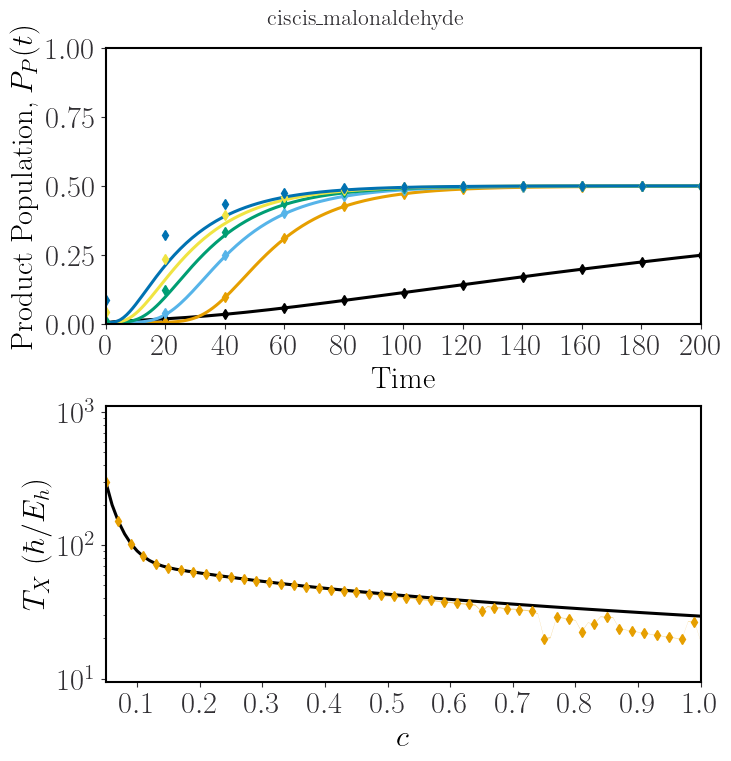

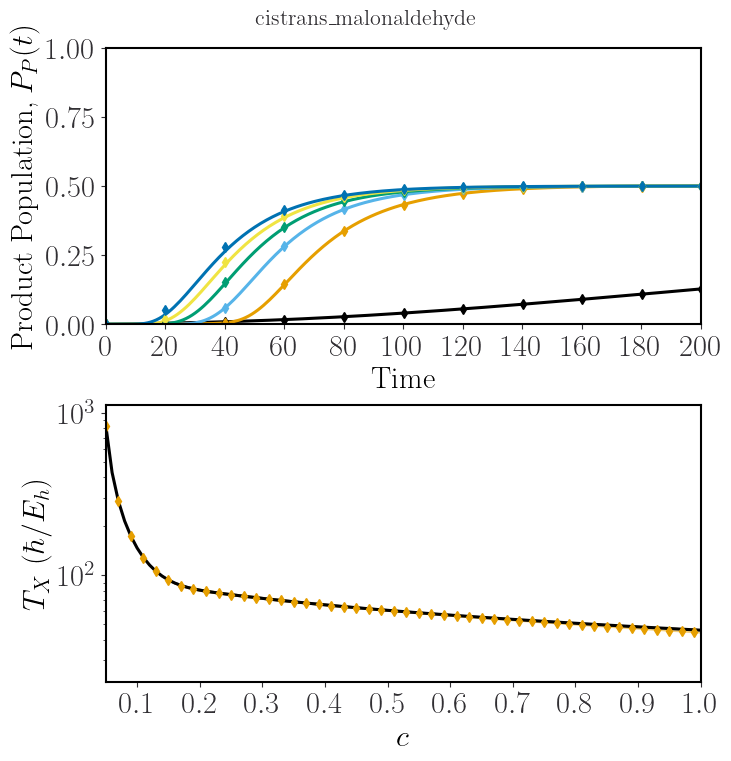

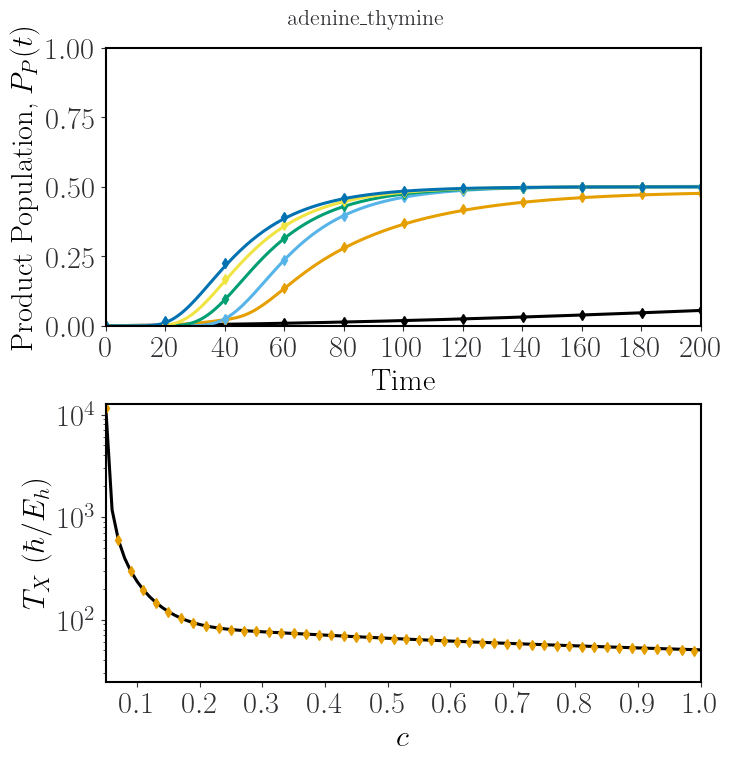

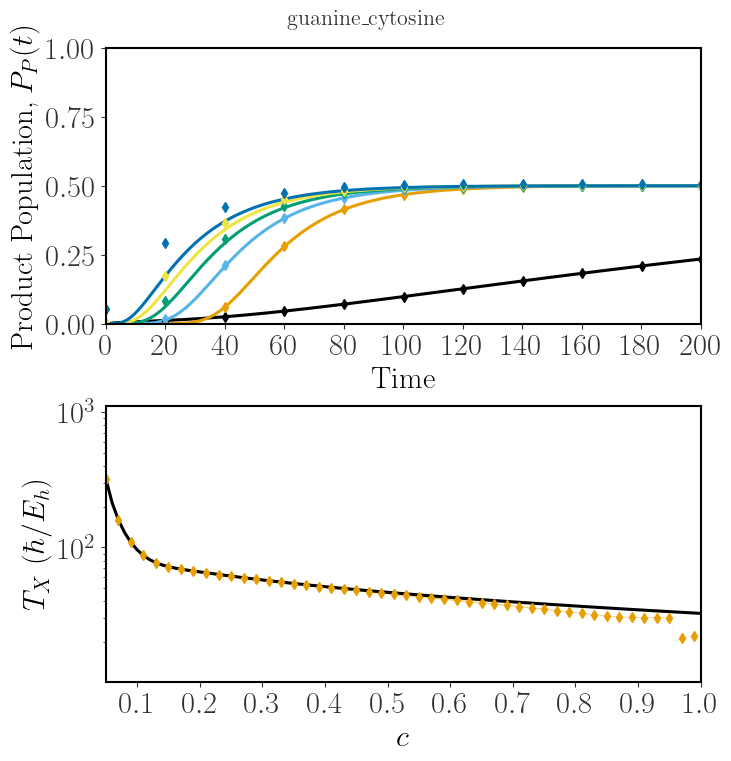

In [72]:
if plot_results:
    for idx, folder in enumerate(folder_list):
        gamma, nbar = plot_params_dict[folder][0]
        t_lims_spec = plot_params_dict[folder][1]
        print(f'gamma={gamma}, nbar={nbar}')
        for entry in system_list:
            data_KC = get_data_plot_traj(entry, ham_type='KC',
                                         NbF=nbasis_F, NbE=nbasis_E,
                                         gamma=gamma, nbar=nbar,
                                         cmin=0.01, cmax=1.0, cinc=0.01,
                                         tmax=10, tnum=1000,
                                         folder=folder+'/',
                                         LDWcvar='True', obs=observable)
            data_DW = get_data_plot_traj(entry, ham_type='DW',
                                         NbF=nbasis_F, NbE=nbasis_E,
                                         gamma=gamma, nbar=nbar,
                                         cmin=0.01, cmax=1.0, cinc=0.01,
                                         tmax=10, tnum=1000,
                                         folder=folder+'/',
                                         LDWcvar='True', obs=observable)
            print(f'{entry} rates (KC) & '
                  f'${float(data_KC["relax_timescale"][9]):1.2f}\\pm'
                  f'{float(data_KC["timescale_error"][9]):1.2f}$ &')
            print(f'{entry} rates (DW) & '
                  f'${float(data_DW["relax_timescale"][9]):1.2f}\\pm'
                  f'{float(data_DW["timescale_error"][9]):1.2f}$ &')
    
            # choosing which segments of the trajectory data to plot
            npts_kc_traj = int((plot_params_dict[folder][1][1]
                                - plot_params_dict[folder][1][0])
                               / (20*plot_params_dict[folder][1][2]))
            dw_traj_data = np.vstack((data_DW['obs_data'][4],
                                      data_DW['obs_data'][19::20]))
            kc_traj_data = np.vstack((data_KC['obs_data'][4,
                                                          ::npts_kc_traj],
                                      data_KC['obs_data'][19::20,
                                                          ::npts_kc_traj]))
            # choosing the corresponding labels
            kc_traj_labels = np.hstack((data_KC['cvalz'][4],
                                        data_KC['cvalz'][19::20]))
            dw_traj_labels = np.hstack((data_DW['cvalz'][4],
                                        data_DW['cvalz'][19::20]))
    
            get_traj_plot([data_DW['time'], data_KC['time'][::npts_kc_traj],
                           data_DW['cvalz'][4:], data_KC['cvalz'][4:]],
                          [dw_traj_data, kc_traj_data,
                           data_DW['relax_timescale'][4:].T,
                           data_KC['relax_timescale'][4:].T],
                          obs=observable,
                          t_clims=(0.05, 1.00, 0.1),
                          tx_lims=(0.0, 10e2, 1.0),
                          t_lims=t_lims_spec,
                          pop_lims=(0.0, 1.0, 0.1),
                          data_label=[dw_traj_labels, kc_traj_labels],
                          plt_traj=True,
                          plt_Tx=True,
                          phi_zps=False,
                          plt_KC=True, plt_DW=True, LDWcvar=True,
                          tx_yscale='log',
                          outdir='./', savename=folder, system=entry,
                          plt_Txerror=True,
                          Tx_error=[data_DW['timescale_error'][4:].T,
                                    data_KC['timescale_error'][4:].T])